In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed
from lowda import load_galaxy
import lowda as lwd

In [3]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [4]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [5]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [6]:
snapnum = 40
z = meta['redshift'][snapnum]
tuniv = meta['time'][snapnum]

print('snapnum=', snapnum)
print('z=', z)
print('tuniv=', tuniv)

snapnum= 40
z= 1.4955121664955557
tuniv= 4.292907980150009


In [7]:
%%time
sub_fields = ['SubhaloSFRinRad', 'SubhaloMassInRadType', 'SubhaloParent', 
              'SubhaloHalfmassRadType', 'SubhaloPos']
subs = il.groupcat.loadSubhalos(TNGbase, snapnum, fields=sub_fields)

halo_fields = ['GroupFirstSub', 'GroupMassType']
halos = il.groupcat.loadHalos(TNGbase, snapnum, fields=halo_fields)

CPU times: user 1.93 s, sys: 3.16 s, total: 5.1 s
Wall time: 38.2 s


In [8]:
arr = halos['GroupFirstSub']
arr = arr[arr >= 0]
is_central = np.full(len(subs['SubhaloSFRinRad']), False)
is_central[arr] = True

stmass = subs['SubhaloMassInRadType'][:,4]
logstmass = np.log10(1e10*stmass, where=stmass > 0)
in_massband = np.logical_and(10 < logstmass, logstmass < 10.5)

is_central_in_massband = np.logical_and(is_central, in_massband)
subIDs = np.where(is_central_in_massband)[0]

In [9]:
def get_SFH(snapnum, subID, tbins, subs, logFeH0_list, rhalf_fac=2):
    # load snap
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_Metals']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['Masses']
    
    # get stars with rhalf_fac*rhalf of center
    pos = snap['Coordinates'] - subs['SubhaloPos'][subID]
    r = np.linalg.norm(pos, axis=1)
    rhalf = subs['SubhaloHalfmassRadType'][subID,4]
    key = np.logical_and(r < rhalf_fac * rhalf, snap['GFM_StellarFormationTime'] > 0)
    
    # get SFH
    sfh = np.zeros((len(tbins)-1, len(logFeH0_list)+1))
    
    dt = tbins[1] - tbins[0]
    sfh[:,0], edges = np.histogram(tform[key], bins=tbins, weights=10*mass[key]/dt)
    
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    # now split by Fe, Mg
    GFM_SOLAR_ABUNDANCE_HYDROGEN  = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON      = 0.0013
    
    FeH = snap['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = snap['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH0 = 0.1
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        in_SN   = np.logical_and(r > rhalf, r < 2*rhalf)
        is_star = snap['GFM_StellarFormationTime'] > 0
        is_star_in_SN = np.logical_and(is_star, in_SN)
        key_    = np.logical_and(np.logical_and(in_FeH, in_SN), is_star)
        
        sfh[:,i+1], edges = np.histogram(tform[key_], bins=tbins, weights=10*mass[key_]/dt/dlogFeH0)
        
        keys.append(key_)
    
    return tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN


In [18]:
def make_plot(subID, output_dir, slope=0):
    tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN = \
        get_SFH(snapnum, subID, tbins, subs, logFeH0_list)

    # given as a positive number, so make negative
    slope *= -1
    t_snapnum = meta['time'][snapnum]
    logMgFe += slope * (tform - t_snapnum)
    
    fig, axs = plt.subplots(3, 1, figsize=(3, 8))

    axs[0].axhline(1, c='k', alpha=0.25)
    axs[0].axhline(2, c='k', alpha=0.25)

    axs[0].plot(tcenter, sfh[:,0], c='k')
    axs[0].set(xlim=(0, t_snapnum))
    axs[0].set(ylim=(0, 25))
    axs[0].set_yticks(np.arange(0, 25+1, 1), minor=True)
    axs[0].set_title(str(subID))
    
    for i in range(1, sfh.shape[1]):
        axs[1].plot(tcenter, sfh[:,i])

    axs[1].set(xlim=(0, t_snapnum), ylim=(0, 25))
    
    offset = 0
    doffset = -0.25
    for key in keys:
        axs[2].scatter(tform[key], logMgFe[key]+offset, s=0.5, alpha=0.1)
        offset += doffset
    
    axs[2].set(xlim=(0, t_snapnum), ylim=(-0.75, 0.75))
    
    fig.savefig(output_dir + '/'+str(subID)+'_sfh.png')
    
    plt.close()
    
    ## now bimodality plot
    fig, axs = plt.subplots(2, 1, figsize=(3, 6))
    logFeH_lim = (-1.5, 0.5)
    logMgFe_lim = (0.2, 1.0)
    N_FeH = 125
    N_MgFe = 125
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    H, _, _, _ = binned_statistic_2d(logFeH[is_star_in_SN], logMgFe[is_star_in_SN], 
                                     np.ones(np.sum(is_star_in_SN))/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    im = axs[0].imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                    logMgFe_lim[0], logMgFe_lim[1]],
                       cmap='Greys', norm=mpl.colors.LogNorm())
    
    axs[0].set(xlim=logFeH_lim, ylim=logMgFe_lim)
    axs[0].set_aspect('auto')
    
    dlogFeH0 = 0.05
    d = 0.25/2
    offset_list = [d, 0.25+d, 0.5+d, 0.75+d]
    # for i,(logFeH0, c) in enumerate(zip(logFeH0_list, [tb_c[0], tb_c[1], tb_c[2], tb_c[4]])):
    for i,logFeH0 in enumerate(logFeH0_list):
        offset = offset_list[i]
        key = np.logical_and(logFeH > logFeH0 - dlogFeH0/2., logFeH < logFeH0 + dlogFeH0/2.)
        key = np.logical_and(key, is_star_in_SN)
    
        bins = np.linspace(-d, 1+d, 200+1)
        binsplot = 0.5*(bins[1:] + bins[:-1])
        hist, _ = np.histogram(logMgFe[key]-np.median(logMgFe[key])+offset, 
                               bins=bins, density=True)
        l = axs[1].plot(binsplot, hist, lw=1)
    
        axs[0].axvline(logFeH0, c=l[0].get_color())
        
        offset += doffset
    
    axs[1].set(ylim=(0, 20), xlim=(bins[0], bins[-1]))
    axs[0].set_title(str(subID))
    
    fig.savefig(output_dir + '/'+str(subID)+'_plane.png')
    
    plt.close()

In [19]:
t_snapnum = meta['time'][snapnum]
tbins = np.linspace(0, t_snapnum, 100)
logFeH0_list = [-0.75, -0.5, -0.25, 0]

for subID in tqdm(subIDs):
# for subID in tqdm([subIDs[0]]):
    make_plot(subID, 'PSB_sfh', slope=0)

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_1032009/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))
100%|██████████| 168/168 [01:11<00:00,  2.37it/s]


In [20]:
for subID in tqdm(subIDs):
    make_plot(subID, 'PSB_sfh_s0.1', slope=0.1)

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_1032009/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))
100%|██████████| 168/168 [01:12<00:00,  2.30it/s]


In [ ]:
def get_MgFe(snapnum, subID, tbins, subs, rhalf_fac=2):
    # load snap
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['Masses']
    
    # get stars with rhalf_fac*rhalf of center
    pos = snap['Coordinates'] - subs['SubhaloPos'][subID]
    r = np.linalg.norm(pos, axis=1)
    rhalf = subs['SubhaloHalfmassRadType'][subID,4]
    key = np.logical_and(r < rhalf_fac * rhalf, snap['GFM_StellarFormationTime'] > 0)
    
    # get SFH
    dt = tbins[1] - tbins[0]
    sfh, edges = np.histogram(tform[key], bins=tbins, weights=10*mass[key]/dt)
    
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    return tcenter, sfh


# interactive figure

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

/tmp/ipykernel_1023833/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))


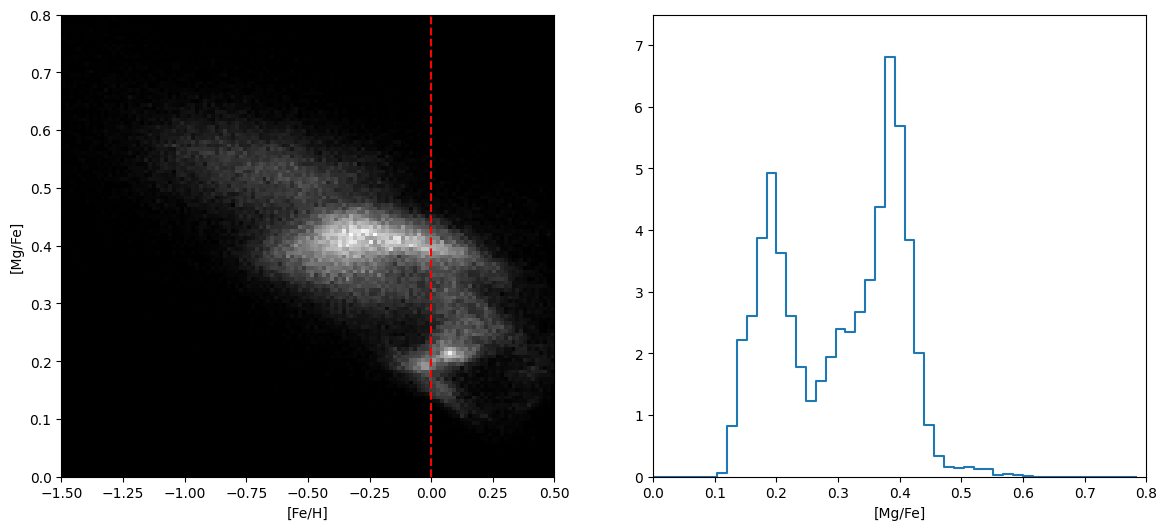

interactive(children=(IntSlider(value=37, description='i:', max=50), Output()), _dom_classes=('widget-interact…

<function __main__.update_plot(x_value)>

In [31]:
subID = 208817

snapnum = 40
t_snapnum = meta['time'][snapnum]
tbins = np.linspace(0, t_snapnum, 100)
logFeH0_list = [-0.75, -0.5, -0.25, 0]

tcenter, sfh, tform, logFeH, logMgFe, _, is_star_in_SN = \
        get_SFH(snapnum, subID, tbins, subs, logFeH0_list)

# simplify things
tform = tform[is_star_in_SN]
logFeH = logFeH[is_star_in_SN]
logMgFe = logMgFe[is_star_in_SN]

data = np.vstack([logFeH, logMgFe]).T

# Create a 2D histogram (heatmap)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[-3, 3], [-3, 3]])

logFeH_lim = (-1.5, 0.5)
logMgFe_lim = (0, 0.8)
N_FeH = 125
N_MgFe = 125
FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, 
                                     np.ones_like(logFeH)/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])

# Precompute 1D histograms for different x values
logFeH_bins = np.linspace(logFeH_lim[0], logFeH_lim[1], 50+1)
logMgFe_hists = []

for i in range(len(logFeH_bins) - 1):
    mask = (logFeH >= logFeH_bins[i]) & (logFeH < logFeH_bins[i+1])
    logMgFe_hist, logMgFe_edges = np.histogram(logMgFe[mask], bins=50, density=True, range=logMgFe_lim)
    logMgFe_hists.append((logMgFe_hist, logMgFe_edges))

logFeH_list = 0.5*(logFeH_bins[1:] + logFeH_bins[:-1])
i0 = np.argmin(np.abs(logFeH_list))
logFeH0 = logFeH_list[i0]
    
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))

extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
heatmap_plot = ax0.imshow(H.T, origin='lower', aspect='auto', extent=extent, cmap='gray')
ax0.set_xlabel('[Fe/H]')
ax0.set_ylabel('[Mg/Fe]')

vline = ax0.axvline(x=logFeH0, color='red', linestyle='--')
logMgFe_hist, logMgFe_edges = logMgFe_hists[i0]
hist_plot, = ax1.step(logMgFe_edges[:-1], logMgFe_hist, where='mid')
ax1.set_xlim(logMgFe_lim[0], logMgFe_lim[1])
ax1.set_ylim(0, max(logMgFe_hist) * 1.1)  # Adjust the y-axis limit to fit the histogram
ax1.set_xlabel('[Mg/Fe]')
    
# Function to update the plot based on the slider
def update_plot(x_value):
    # Update the vertical line position
    vline.set_xdata(logFeH_list[x_value])
    
    # Update the conditional 1D histogram
    logMgFe_hist, logMgFe_edges = logMgFe_hists[x_value]
    hist_plot.set_xdata(logMgFe_edges[:-1])
    hist_plot.set_ydata(logMgFe_hist)
    
    # Update the title of the histogram plot
    ax1.set_title('[Fe/H]='+str(round(logFeH_list[x_value], 2)))
    
    # Redraw the updated plots
    print('hi')
    fig.canvas.draw_idle()
    fig.canvas.flush_events()
    
    plt.show()

# Create the slider
x_slider = IntSlider(value=i0, min=0, max=len(logFeH_list), description='i:')

# Use the interact function to link the slider and the update_plot function
interact(update_plot, x_value=x_slider)


interactive(children=(FloatSlider(value=0.0, description='X Value:', max=3.0, min=-3.0), Output()), _dom_class…

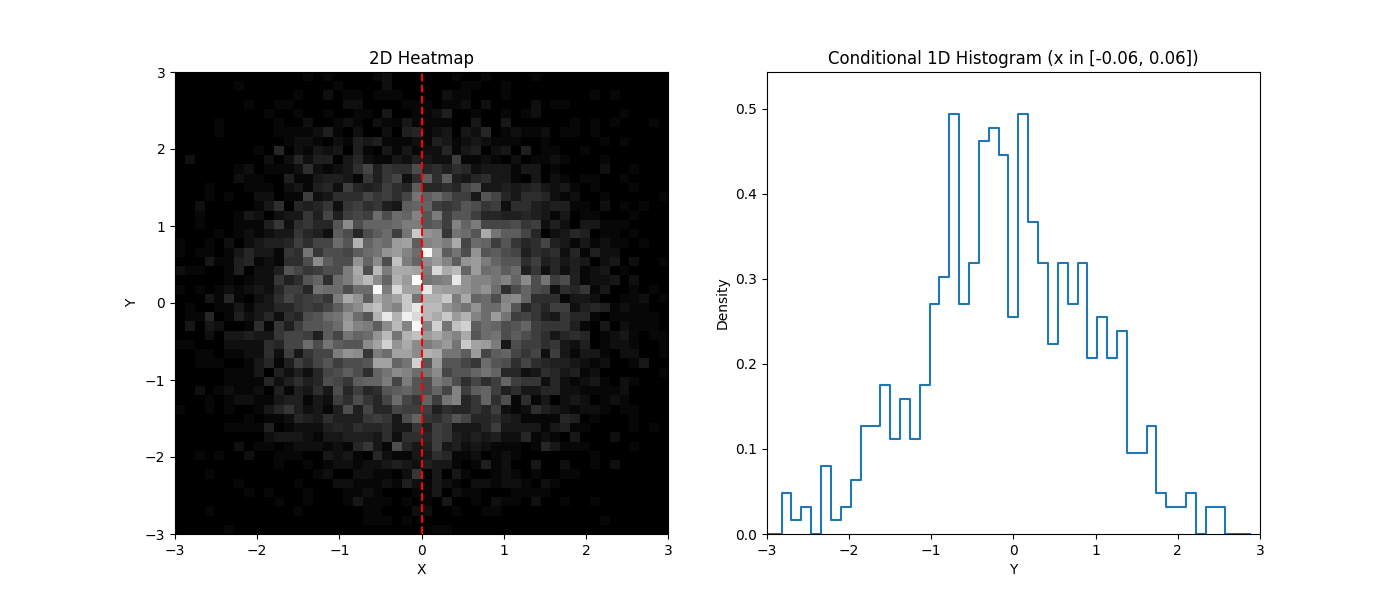

In [1]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Generate sample data
np.random.seed(0)
x = np.random.randn(10000)
y = np.random.randn(10000)
data = np.vstack([x, y]).T

# Create a 2D histogram (heatmap)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[-3, 3], [-3, 3]])

# Precompute 1D histograms for different x values
x_bins = np.linspace(-3, 3, 50)
y_histograms = []

for i in range(len(x_bins) - 1):
    mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
    y_hist, y_edges = np.histogram(y[mask], bins=50, density=True, range=[-3, 3])
    y_histograms.append((y_hist, y_edges))

# Initial plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the 2D heatmap
heatmap_plot = ax1.imshow(heatmap.T, origin='lower', aspect='auto', extent=[-3, 3, -3, 3], cmap='gray')
ax1.set_title('2D Heatmap')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Add a vertical line at the initial x_value
vline = ax1.axvline(x=0, color='red', linestyle='--')

# Initial plot for the conditional 1D histogram
y_hist, y_edges = y_histograms[0]
hist_plot, = ax2.step(y_edges[:-1], y_hist, where='mid')
ax2.set_xlim(-3, 3)
ax2.set_ylim(0, max(y_hist) * 1.1)  # Adjust the y-axis limit to fit the histogram
ax2.set_title(f'Conditional 1D Histogram (x in [{x_bins[0]:.2f}, {x_bins[1]:.2f}])')
ax2.set_xlabel('Y')
ax2.set_ylabel('Density')

# Function to update the plot based on the slider
def update_plot(x_value):
    # Update the vertical line position
    vline.set_xdata(x_value)
    
    # Find the closest x_bin
    bin_idx = np.digitize(x_value, x_bins) - 1
    bin_idx = min(max(bin_idx, 0), len(x_bins) - 2)
    
    # Update the conditional 1D histogram
    y_hist, y_edges = y_histograms[bin_idx]
    hist_plot.set_data(y_edges[:-1], y_hist)
    ax2.set_ylim(0, max(y_hist) * 1.1)  # Adjust the y-axis limit to fit the histogram
    
    # Update the title of the histogram plot
    ax2.set_title(f'Conditional 1D Histogram (x in [{x_bins[bin_idx]:.2f}, {x_bins[bin_idx + 1]:.2f}])')
    
    # Redraw the updated plots
    fig.canvas.draw()

# Create the slider
x_slider = FloatSlider(value=0, min=-3, max=3, step=0.1, description='X Value:')

# Use the interact function to link the slider and the update_plot function
interact(update_plot, x_value=x_slider)

plt.show()
